<a href="https://colab.research.google.com/github/rmorlowski/Regression-Analysis-and-Multivariate-Methods/blob/master/PCA_Factor_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PCA & Factor Analysis

The deliverable is to analyze survey data from restaurant customer responses to find the most important variables to explain overall restaurant ratings. The goal is to find some meaningful information from the data to provide a recommendation to the restaurant owner. This will be accomplished by comparing the full multiple regression model against the principle components and factor analysis methods. From these techniques, the best model will be selected by comparing VIF values, adjusted R-squared, and RMSE scores.

In [0]:
# import packages for this example
import pandas as pd      
import numpy as np  # arrays and math functions
import matplotlib.pyplot as plt  # static plotting
from sklearn.decomposition import PCA, FactorAnalysis
import statsmodels.formula.api as smf  # R-like model specification
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [0]:
#Set some display options   
pd.set_option('display.notebook_repr_html', False) 
pd.set_option('display.max_columns', 40) 
pd.set_option('display.max_rows', 10) 
pd.set_option('display.width', 120)

In [0]:
#Read in the restaurant dataset
food_df = pd.read_csv('/Users/rmorlows/Desktop/MSDS410/Assignment 03/FACTOR1.csv')
#A good step to take is to convert all variable names to lower case
food_df.columns = [s.lower() for s in food_df.columns]
#print(food_df)

In [0]:
#This assignment is a tutorial so have a bit of fun with it
#If you would like to explore some additional options give it a try
#Goal is to provide some meaningful info to the restaurant owner
#Some notes below
#Both PCA and FA provide useful summary info for multivariate data, but
#all of the original variables are needed for their calculation, so 
#the big question is can we use them to find a subset of variables to 
#predict overall score?
#Also,trying to give meaningful labels to components is really hard.
#When the variables are on different scales you need to work with the 
#correlation matrix.  For this assignment they are on same scale so
#we will work with the raw data.
#PCA only helps if the original variables are correlated, if they 
#are independent PCA will not help.
#Approach takes two steps
#First step find the dimensionality of the data, that is the 
#number of original variables to be retained
#Second step find which ones, more on this below

In [0]:
print('')
print('----- Summary of Input Data -----')
print('')


----- Summary of Input Data -----



In [0]:
# show the object is a DataFrame
print('Object type: ', type(food_df))

Object type:  <class 'pandas.core.frame.DataFrame'>


In [0]:
# show number of observations in the DataFrame
print('Number of observations: ', len(food_df))

Number of observations:  1000


In [0]:
# show variable names
print('Variable names: ', food_df.columns)

Variable names:  Index(['index', 'taste', 'temp', 'freshness', 'wait', 'clean', 'friend', 'location', 'parking', 'view', 'overall'], dtype='object')


In [0]:
# show descriptive statistics
print(food_df.describe())

             index        taste         temp    freshness         wait        clean       friend     location  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean    500.500000     6.001000     6.682000     6.054000     4.962000     5.637000     4.976000     7.022000   
std     288.819436     1.064017     1.384483     1.479619     1.038091     1.373724     1.446899     1.058601   
min       1.000000     2.000000     2.000000     1.000000     1.000000     2.000000     1.000000     4.000000   
25%     250.750000     5.000000     6.000000     5.000000     4.000000     5.000000     4.000000     6.000000   
50%     500.500000     6.000000     7.000000     6.000000     5.000000     6.000000     5.000000     7.000000   
75%     750.250000     7.000000     8.000000     7.000000     6.000000     7.000000     6.000000     8.000000   
max    1000.000000     9.000000    10.000000    10.000000     9.000000    10.000000     9.000000

In [0]:
# show a portion of the beginning of the DataFrame
print(food_df.head())

   index  taste  temp  freshness  wait  clean  friend  location  parking  view  overall
0      1      6     7          8     4      5       5         8        8     7        6
1      2      5     5          6     5      6       4         8        9     9        6
2      3      6     7          5     7      8       8         6        8     4        6
3      4      7     9          6     5      6       4         7        7     7        6
4      5      7     8          6     3      3       3         6        7     6        6


In [0]:
#look at correlation structure
cdata = food_df.loc[:,['overall','taste','temp','freshness','wait','clean','friend','location','parking','view']] 
corr = cdata[cdata.columns].corr()
print(corr)
#Use the correlation matrix to help provide advice to the restaurant owner

            overall     taste      temp  freshness      wait     clean    friend  location   parking      view
overall    1.000000  0.601032  0.547054   0.534843  0.427564  0.405603  0.350008  0.429164  0.399541  0.375520
taste      0.601032  1.000000  0.789812   0.729890 -0.026247  0.009836 -0.038996 -0.018682  0.003060  0.003171
temp       0.547054  0.789812  1.000000   0.589883 -0.007720  0.016614 -0.016306 -0.012297  0.005909  0.021782
freshness  0.534843  0.729890  0.589883   1.000000 -0.009742  0.028860  0.005749 -0.030157 -0.015049  0.004655
wait       0.427564 -0.026247 -0.007720  -0.009742  1.000000  0.779297  0.697821 -0.020189 -0.028527 -0.026728
clean      0.405603  0.009836  0.016614   0.028860  0.779297  1.000000  0.534478 -0.002763 -0.038822 -0.020836
friend     0.350008 -0.038996 -0.016306   0.005749  0.697821  0.534478  1.000000 -0.026450 -0.024107 -0.053633
location   0.429164 -0.018682 -0.012297  -0.030157 -0.020189 -0.002763 -0.026450  1.000000  0.792472  0.712758
p

In [0]:
#Look at four different models and compare them
#Which model do you think is best and why?
#Model 1 full regression model
#Model 2 select my reduced regression model taste, wait and location
#Model 3 Full PCA model
#Model 4 Reduced PCA model with parking, taste and clean
#Model 5 FA model

In [0]:
#First find the PCA
#Second find the FA
#Run the models
#Compare the models and show VIF for each model

In [0]:
print('')
print('----- Principal Component Analysis -----')
print('')


----- Principal Component Analysis -----



In [0]:
#PCA
pca_data = food_df.loc[:,['taste','temp','freshness','wait','clean','friend','location','parking','view']] 
pca = PCA()
P = pca.fit(pca_data)
print(pca_data)
np.set_printoptions(threshold=np.inf) 
np.around([pca.components_], decimals=3)
#Note per Everett p209 pick the three variables with the largest
#absolute coefficient on the component not already picked
#So, choose parking, taste and clean for the PCA variable reduction model

     taste  temp  freshness  wait  clean  friend  location  parking  view
0        6     7          8     4      5       5         8        8     7
1        5     5          6     5      6       4         8        9     9
2        6     7          5     7      8       8         6        8     4
3        7     9          6     5      6       4         7        7     7
4        7     8          6     3      3       3         6        7     6
..     ...   ...        ...   ...    ...     ...       ...      ...   ...
995      6     6          6     4      5       5         6        7     5
996      7     8          8     3      4       3         9       10     9
997      4     5          3     5      6       5         7        8     6
998      5     7          6     3      2       4         6        7     6
999      7     7          7     5      5       4         8       10    10

[1000 rows x 9 columns]


array([[[-0.475, -0.595, -0.645, -0.003, -0.032, -0.001,  0.038,  0.033,
          0.023],
        [-0.033, -0.042, -0.022,  0.284,  0.356,  0.389, -0.379, -0.456,
         -0.535],
        [ 0.003, -0.012, -0.013, -0.384, -0.489, -0.505, -0.296, -0.341,
         -0.393],
        [-0.013, -0.049,  0.092, -0.118, -0.612,  0.664,  0.056,  0.288,
         -0.27 ],
        [-0.117, -0.535,  0.575, -0.039, -0.108,  0.122, -0.099, -0.389,
          0.424],
        [-0.045, -0.421,  0.424,  0.022,  0.255, -0.275,  0.139,  0.476,
         -0.504],
        [-0.073,  0.053,  0.003, -0.688,  0.321,  0.2  ,  0.526, -0.285,
         -0.135],
        [-0.856,  0.412,  0.245, -0.032,  0.03 , -0.021, -0.154,  0.103,
          0.019],
        [ 0.139, -0.07 , -0.063, -0.532,  0.28 ,  0.147, -0.659,  0.35 ,
          0.181]]])

In [0]:
# show summary of pca solution
pca_explained_variance = pca.explained_variance_ratio_
print('Proportion of variance explained:', pca_explained_variance)
# Retain at least 70% of the dataset's original information.
# Results show that first three variables account for approximately 78.2% of the explained variance.

Proportion of variance explained: [0.27051531 0.26603802 0.24572407 0.06231153 0.05578657 0.05420122
 0.01592382 0.01532158 0.01417787]


In [0]:
#Note:  We do not want to explain 100% of the variance
pca.explained_variance_ratio_.sum()

1.0

In [0]:
# note that principal components analysis corresponds
# to finding eigenvalues and eigenvectors of the pca_data
pca_data_cormat = np.corrcoef(pca_data.T)
eigenvalues, eigenvectors = np.linalg.eig(pca_data_cormat)
np.around([eigenvalues], decimals=3)

array([[2.282, 2.414, 2.449, 0.484, 0.429, 0.412, 0.165, 0.175, 0.189]])

In [0]:
print('Linear algebra demonstration: Proportion of variance explained: ',
    eigenvalues/eigenvalues.sum())
np.around([eigenvectors], decimals=3)

Linear algebra demonstration: Proportion of variance explained:  [0.25359443 0.26825439 0.27211982 0.05372803 0.04771918 0.04576782
 0.01836695 0.01949504 0.02095434]


array([[[-0.083,  0.6  , -0.024, -0.008, -0.081,  0.079, -0.246, -0.746,
         -0.058],
        [-0.092,  0.563, -0.024, -0.031, -0.208,  0.597,  0.164,  0.491,
          0.068],
        [-0.086,  0.545, -0.041,  0.081,  0.302, -0.7  ,  0.132,  0.299,
         -0.01 ],
        [-0.479, -0.099, -0.37 , -0.109, -0.049,  0.018,  0.435, -0.099,
         -0.641],
        [-0.452, -0.067, -0.344, -0.551, -0.229, -0.165, -0.321,  0.094,
          0.422],
        [-0.418, -0.093, -0.337,  0.697,  0.296,  0.169, -0.175, -0.002,
          0.266],
        [-0.375, -0.045,  0.478,  0.037, -0.112, -0.056,  0.594, -0.235,
          0.451],
        [-0.345, -0.028,  0.456,  0.29 , -0.507, -0.181, -0.401,  0.191,
         -0.318],
        [-0.329, -0.016,  0.438, -0.326,  0.669,  0.236, -0.243,  0.058,
         -0.167]]])

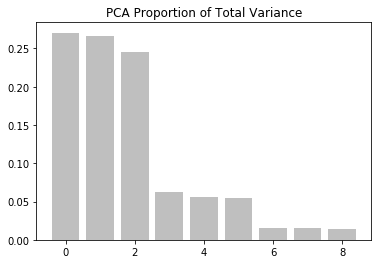

In [0]:
# show the plot for the pricipal component analysis
plt.bar(np.arange(len(pca_explained_variance)), pca_explained_variance, 
    color = 'grey', alpha = 0.5, align = 'center')
plt.title('PCA Proportion of Total Variance')
plt.show()

   eigenvalues  0
0     2.282350  1
1     2.414290  2
2     2.449078  3
3     0.483552  4
4     0.429473  5
5     0.411910  6
6     0.165303  7
7     0.175455  8
8     0.188589  9


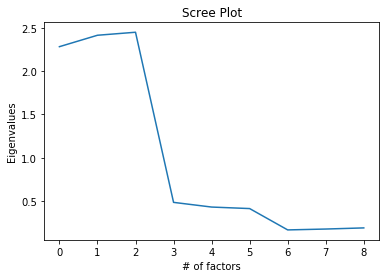

In [0]:
# show a scree plot 
d = {'eigenvalues': eigenvalues }
df1 = pd.DataFrame(data=d)
df2 =pd.Series([1,2,3,4,5,6,7,8,9])
#df2 = {'factors': factors}
# merge eigenvalues with # of factors
result = pd.concat([df1, df2], axis=1, join_axes=[df2.index])
print (result)

def scat(dataframe,var1,var2):
    dataframe[var2].plot()     
    plt.title('Scree Plot')
    plt.xlabel('# of factors')
    plt.ylabel('Eigenvalues')
    
scat(result,'0','eigenvalues')
plt.show()

In [0]:
# provide partial listing of variable loadings on principal components
# transpose for variables by components listing
pca_loadings = pca.components_.T

In [0]:
#variable_names
variable_names = list(food_df.columns.values[1:10])

In [0]:
comps = pd.DataFrame(pca.components_, columns = variable_names)

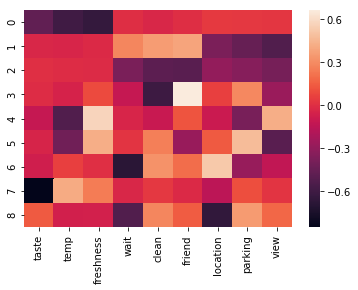

In [0]:
sns.heatmap(comps)

In [0]:
# provide full formatted listing of loadings for first three components
# print loadings while rounding to three digits 
# and suppress printing of very small numbers
# but do not suppress printing of zeroes
np.set_printoptions(precision = 3, suppress = True,
    formatter={'float': '{: 0.3f}'.format})
print(pca_loadings[:,0:3])  

[[-0.475 -0.033  0.003]
 [-0.595 -0.042 -0.012]
 [-0.645 -0.022 -0.013]
 [-0.003  0.284 -0.384]
 [-0.032  0.356 -0.489]
 [-0.001  0.389 -0.505]
 [ 0.038 -0.379 -0.296]
 [ 0.033 -0.456 -0.341]
 [ 0.023 -0.535 -0.393]]


In [0]:
# compute full set of principal components (scores)
C = pca.transform(pca_data)
#print(C)
# add first three principal component scores to the original data frame
pca_data['pca1'] = C[:,0]
pca_data['pca2'] = C[:,1]
pca_data['pca3'] = C[:,2]
#print(pca_data) 
# add first three principal component scores to the food_df
food_df['pca1'] = C[:,0]
food_df['pca2'] = C[:,1]
food_df['pca3'] = C[:,2]
#print(food_df)

In [0]:
# explore relationships between pairs of principal components
# working with the first three components only
pca_scores = pca_data.loc[:,['pca1','pca2', 'pca3']]
pca_model_cormat = \
    np.corrcoef(pca_scores.as_matrix().transpose()).round(decimals=3)
print(pca_model_cormat)
#Looks like that worked

[[ 1.000 -0.000  0.000]
 [-0.000  1.000 -0.000]
 [ 0.000 -0.000  1.000]]


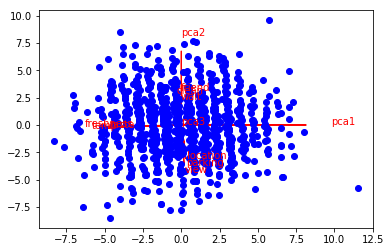

In [0]:
# Creating a Bi-plot
## perform PCA

n = len(pca_data.columns)

pca = PCA(n_components = n)
# defaults number of PCs to number of columns in imported data (ie number of
# features), but can be set to any integer less than or equal to that value

pca.fit(pca_data)

## project data into PC space

# 0,1 denote PC1 and PC2; change values for other PCs
xvector = pca.components_[0]
yvector = pca.components_[1]

xs = pca.transform(pca_data)[:,0]
ys = pca.transform(pca_data)[:,1]

## visualize projections

## Note: scale values for arrows and text are a bit inelegant as of now,
##       so feel free to play around with them

for i in range(len(xs)):
# circles project documents (ie rows from csv) as points onto PC axes
    plt.plot(xs[i], ys[i], 'bo')
    #plt.text(xs[i]*1.2, ys[i]*1.2, list(pca_data.index)[i], color='b')

for i in range(len(xvector)):
# arrows project features (ie columns from csv) as vectors onto PC axes
    plt.arrow(0, 0, xvector[i]*max(xs), yvector[i]*max(ys),
              color='r', width=0.0005, head_width=0.0025)
    plt.text(xvector[i]*max(xs)*1.2, yvector[i]*max(ys)*1.2,
             list(pca_data.columns.values)[i], color='r')

plt.show()

In [0]:
#Factor Analysis
print('')
print('----- Factor Analysis (Unrotated) -----')
print('')


----- Factor Analysis (Unrotated) -----



In [0]:
pca_data

     taste  temp  freshness  wait  clean  friend  location  parking  view      pca1      pca2      pca3
0        6     7          8     4      5       5         8        8     7 -1.374753 -1.051124  0.248970
1        5     5          6     5      6       4         8        9     9  1.627366 -2.166975 -1.198849
2        6     7          5     7      8       8         6        8     4  0.307264  4.463872 -2.070600
3        7     9          6     5      6       4         7        7     7 -1.853539 -0.039391  0.522603
4        7     8          6     3      3       3         6        7     6 -1.216772 -1.106078  3.963076
..     ...   ...        ...   ...    ...     ...       ...      ...   ...       ...       ...       ...
995      6     6          6     4      5       5         6        7     5  0.355509  1.319526  2.007853
996      7     8          8     3      4       3         9       10     9 -2.255716 -4.905627  0.356464
997      4     5          3     5      6       5         7      

In [0]:
from factor_analyzer import FactorAnalyzer

In [0]:
fa = FactorAnalyzer()

In [0]:
fa.analyze(pca_data, 3, rotation=None)

In [0]:
fa.loadings

            Factor1   Factor2   Factor3
taste      0.090249  0.900664  0.119339
temp       0.081708  0.814328  0.128158
freshness  0.106594  0.788133  0.122262
wait       0.532939 -0.182022  0.714958
clean      0.477229 -0.125435  0.646110
...             ...       ...       ...
parking   -0.674456  0.002300  0.464006
view      -0.656827  0.019800  0.449538
pca1      -0.171275 -1.000446 -0.138406
pca2       1.010442 -0.173062  0.000971
pca3       0.022520  0.136378 -1.016809

[12 rows x 3 columns]

In [0]:
fa.get_uniqueness()

           Uniqueness
taste        0.166418
temp         0.313769
freshness    0.352536
wait         0.171679
clean        0.339061
...               ...
parking      0.329802
view         0.366102
pca1        -0.049384
pca2        -0.050945
pca3        -0.053006

[12 rows x 1 columns]

In [0]:
fa.get_factor_variance()

                 Factor1   Factor2   Factor3
SS Loadings     3.242291  3.220586  3.079912
Proportion Var  0.270191  0.268382  0.256659
Cumulative Var  0.270191  0.538573  0.795232

In [0]:
# assume three factors will be sufficient 
# this is an unrotated orthogonal solution
# maximum likelihood estimation is employed
# for best results set tolerance low and max iterations high
fa = FactorAnalysis(n_components = 3, tol=1e-8, max_iter=1000000)

In [0]:
#the unrotated solution
fa.fit(pca_data)

FactorAnalysis(copy=True, iterated_power=3, max_iter=1000000, n_components=3,
        noise_variance_init=None, random_state=0, svd_method='randomized',
        tol=1e-08)

In [0]:
# retrieve the factor loadings as an array of arrays
# transpose for variables by factors listing of loadings
fa_loadings = fa.components_.T
#print(fa_loadings)

In [0]:
# show the loadings of the variables on the factors
# for the unrotated maximum likelihood solution
# print loadings while rounding to three digits 
# and suppress printing of very small numbers
# but do not suppress printing of zeroes
np.set_printoptions(precision = 3, suppress = True,
    formatter={'float': '{: 0.3f}'.format})
#print(fa_loadings)  

In [0]:
# compute full set of factor scores
F = fa.transform(pca_data)
#print(F)
# add factor scores to the original data frame
food_df['fa1'] = F[:,0]
food_df['fa2'] = F[:,1]
food_df['fa3'] = F[:,2]
#print(food_df) 

In [0]:
#Look at five different models and compare them
#Which model do you think is best and why?
#Model 1 full regression model
#Model 2 select my reduced regression model taste, wait and location
#Model 3 Full PCA model
#Model 4 Reduced PCA model with parking, taste and clean
#Model 5 FA model

In [0]:
#Run the Models
#Model 1 full model
regress_model_fit = smf.ols(formula = 'overall~taste+temp+freshness+wait+clean+friend+location+parking+view', data = food_df).fit()
# summary of model fit  
print(regress_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                overall   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     507.9
Date:                Tue, 21 Aug 2018   Prob (F-statistic):               0.00
Time:                        14:24:22   Log-Likelihood:                -179.96
No. Observations:                1000   AIC:                             379.9
Df Residuals:                     990   BIC:                             429.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0745      0.094      0.789      0.4

In [0]:
y = food_df['overall']

In [0]:
# RMSE Model 1
y_pred = regress_model_fit.fittedvalues
print(np.sqrt(mean_squared_error(y, y_pred)))

0.2896803884073767


In [0]:
#Model 2
#Note, Model 2 is a choice from looking at the correlation, you may choose a
#different selection for this if you like, just explain why 
regress_model_fit = smf.ols(formula = 'overall~taste+wait+location', data = food_df).fit()
# summary of model fit  
print(regress_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                overall   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     1052.
Date:                Tue, 21 Aug 2018   Prob (F-statistic):          3.27e-308
Time:                        14:24:22   Log-Likelihood:                -328.95
No. Observations:                1000   AIC:                             665.9
Df Residuals:                     996   BIC:                             685.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2025      0.109      1.864      0.0

In [0]:
# RMSE Model 2
y_pred = regress_model_fit.fittedvalues
print(np.sqrt(mean_squared_error(y, y_pred)))

0.3362196675363941


In [0]:
#Model 3
#regress the response overall on principal components
pca_model_fit = smf.ols(formula = 'overall~pca1+pca2+pca3', data = food_df).fit()
# summary of model fit  
print(pca_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                overall   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     1315.
Date:                Tue, 21 Aug 2018   Prob (F-statistic):               0.00
Time:                        14:24:22   Log-Likelihood:                -241.98
No. Observations:                1000   AIC:                             492.0
Df Residuals:                     996   BIC:                             511.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.1470      0.010    629.417      0.0

In [0]:
# RMSE Model 3
y_pred = pca_model_fit.fittedvalues
print(np.sqrt(mean_squared_error(y, y_pred)))

0.30821548293411843


In [0]:
#Model 4
#regress the response overall on principal components
pca_model_fit = smf.ols(formula = 'overall~parking+taste+clean', data = food_df).fit()
# summary of model fit  
print(pca_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                overall   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     746.0
Date:                Tue, 21 Aug 2018   Prob (F-statistic):          3.99e-254
Time:                        14:24:22   Log-Likelihood:                -454.03
No. Observations:                1000   AIC:                             916.1
Df Residuals:                     996   BIC:                             935.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0053      0.111      9.023      0.0

In [0]:
# RMSE Model 4
y_pred = pca_model_fit.fittedvalues
print(np.sqrt(mean_squared_error(y, y_pred)))

0.3810188964409711


In [0]:
#Model 5 
#regress the response overall on factor scores
fa_model_fit = smf.ols(formula = 'overall~fa1+fa2+fa3', data = food_df).fit()
# summary of model fit  
print(fa_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                overall   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     1315.
Date:                Tue, 21 Aug 2018   Prob (F-statistic):               0.00
Time:                        14:24:22   Log-Likelihood:                -241.98
No. Observations:                1000   AIC:                             492.0
Df Residuals:                     996   BIC:                             511.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.1470      0.010    629.419      0.0

In [0]:
# RMSE Model 5
y_pred = fa_model_fit.fittedvalues
print(np.sqrt(mean_squared_error(y, y_pred)))

0.30821437788593625


In [0]:
#next look at VIF to see what the full, choice, PCA and FA models did
# Break into left and right hand side; y and X then find VIF for each model
import statsmodels.formula.api as sm
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
y = food_df.loc[:,['overall']]
X = food_df.loc[:,['taste','temp','freshness','wait','clean','friend','location','parking','view']]
y, X = dmatrices('overall ~ taste+temp+freshness+wait+clean+friend+location+parking+view ', data=food_df, return_type="dataframe")

In [0]:
# For each Xi, calculate VIF
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print('')
print('----- VIF for Full Regression Model -----')
print('')
print(vif)


----- VIF for Full Regression Model -----

[105.31057172729297, 3.7339305023025977, 2.666947996579803, 2.155696222950924, 3.5665022511678393, 2.5722838192097766, 1.9647506059999644, 3.7231101190624267, 2.7064357263205463, 2.046687628686198]


In [0]:
#VIF for choice model
y = food_df.loc[:,['overall']]
X = food_df.loc[:,['taste','clean','location']] 
y, X = dmatrices('overall ~ taste+clean+location ', data=food_df, return_type="dataframe")
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print('')
print('----- VIF for Choice Model -----')
print('')
print(vif)


----- VIF for Choice Model -----

[94.85693832611108, 1.0004449628183567, 1.0001034182425719, 1.0003558038219071]


In [0]:
#VIF for PCA
y = food_df.loc[:,['overall']]
X = food_df.loc[:,['pca1','pca2','pca3']] 
y, X = dmatrices('overall ~ pca1+pca2+pca3 ', data=food_df, return_type="dataframe")
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print('')
print('----- VIF for PCA Model -----')
print('')
print(vif)


----- VIF for PCA Model -----

[0.9999999999999998, 1.0, 1.0000000000000002, 1.0]


In [0]:
#VIF for FA
y = food_df.loc[:,['overall']]
X = food_df.loc[:,['fa1','fa2','fa3']] 
y, X = dmatrices('overall ~ fa1+fa2+fa3 ', data=food_df, return_type="dataframe")
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print('')
print('----- VIF for FA Model -----')
print('')
print(vif)


----- VIF for FA Model -----

[1.0, 1.0, 1.0000000000000002, 1.0000000000000002]


In [0]:
#Which model do you like best and why?
#For the full regression model sum the coefficients for each three variable
#grouping, taste, temp freshness group 1
group1_coeff = 0.2249 + 0.0788 + 0.0899
print(group1_coeff)
#wait, clean, friend group 2
group2_coeff = 0.1706 + 0.0660 + 0.0625
print(group2_coeff)
# location, parking, view group 3
group3_coeff = 0.1552 + 0.0797 + 0.0597
print(group3_coeff)
print(group1_coeff + group2_coeff + group3_coeff)
#How do you interpret this info?
#Compare with the choice model

0.39359999999999995
0.29910000000000003
0.2946
0.9873


In [0]:
#Principle Components Analysis (PCA)
# Uncorrelated features that emobody a dateset's important information ("it's variance") with the redundancy, noise, and outliers stripped out.

In [0]:
#Factor Analysis
# A method used to explore datasets to find root causes to explain why data is acting a certain way.
# Factors (aka latent variables) = variables that are quite meaningful, but are inferred and not directly observable.
# Synthetic representations of our dataset with extra dimensionality and information redudundancy stripped-out.

#  FA Assumptions
#1) features are metric
#2) features are continuous or ordinal
#3) There is r > 0.3 for the features in the dataset
#4) You have greater than > 100 observations and > 5 observations per feature
#5) Sample is homogenous

#### Conclusion

Several models were developed and tested to predict overall restaurant ratings using survey data. The two best multiple regression models were derived using principle component and factor analysis. Both models removed the noise to help explain our dataset with fewer variables. The PCA model was selected, as it is easier to explain the component variables.

In visualizing our PCA analysis, it was easier to identify the variances and component variables. The first component reflects food quality since the heatmap shows a strong negative correlation with these variables. The second principle component reflects service. The third principle component reflects convenience. The principle components were confirmed using the biplot visualization.

To answer the question, the restaurant owner should focus on food quality to raise the overall rating. When this principle component variable was removed from the regression, it had the largest change on the adjusted R-squared value. My recommendation would be to not have bad food, or conversely have good food!